In [ ]:
# Basic libraries
import numpy as np
import pandas as pd

## NLP libraries
import re
import string
import nltk
from nltk.corpus import stopwords

## ML Libraries
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier


## Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap
from scipy.stats import chi2_contingency
from subprocess import check_output

#Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


In [ ]:
data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",")
test_csv = pd.read_csv(data_url + 'test.csv', sep=",")

 **Understanding Data**

In [ ]:
# let's take a look at the data
display(train_csv.head())
display(test_csv.head())

Y_train = train_csv['target'].values
X_train = train_csv.values[:, 1:4] # extracting the columns keyword, location and text (without id)

# let's print one example to check we picked the right columns
print(X_train[0])

X_test_text = test_csv['text']
X_test_id = test_csv['id'].values
# these are needed to build output prediction files if you want to submit your predictions to the Kaggle website (see format of the submission)

print(Y_train.shape, X_test_id.shape, X_train.shape)

# create a dummy pessimistic predictor that always says DISASTER (class 1)
test_predictions = np.ones((len(X_test_id),1), dtype=int)

# download_predictions_to_file(X_test_id, test_predictions) # download the prediction file


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


[nan nan
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
(7613,) (3263,) (7613, 3)


In [ ]:
train_csv.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test_csv.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Check number of unique keywords, and whether they are the same for train and test sets**

In [ ]:
print (train_csv.keyword.nunique(), test_csv.keyword.nunique())

221 221


**Most common words**

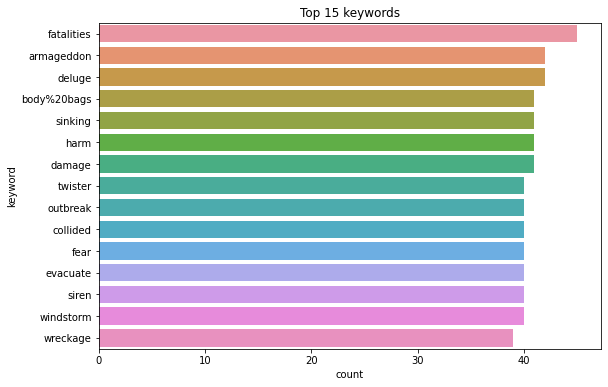

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_csv.keyword, order = train_csv.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

**Top 10 words in disaster and non-disaster tweets**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


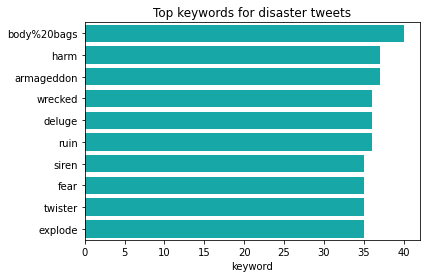

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


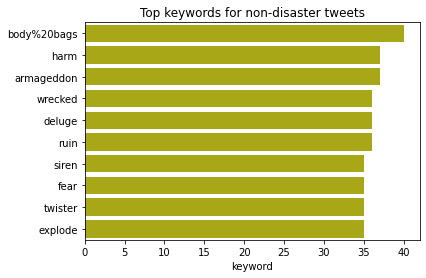

In [ ]:
kw_nd = train_csv[train_csv.target==0].keyword.value_counts().head(10)

sns.barplot(kw_nd, kw_nd.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.show()
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

There is no common top 10 keywords between disaster and non-disaster tweets.

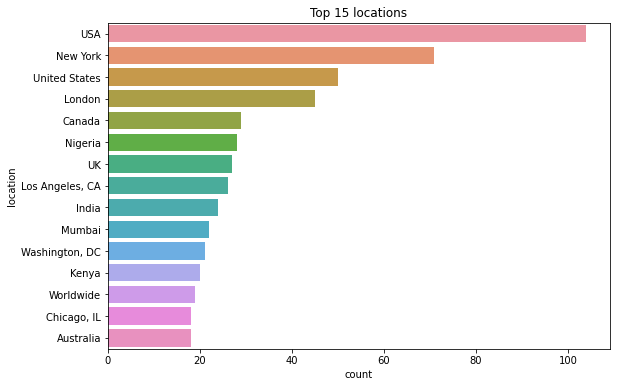

In [ ]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train_csv.location, order = train_csv.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

As location is free text, the data is not clean, you can see both 'USA' and 'United States' in top locations. We than have a look at % of **disaster** tweets for common locations.

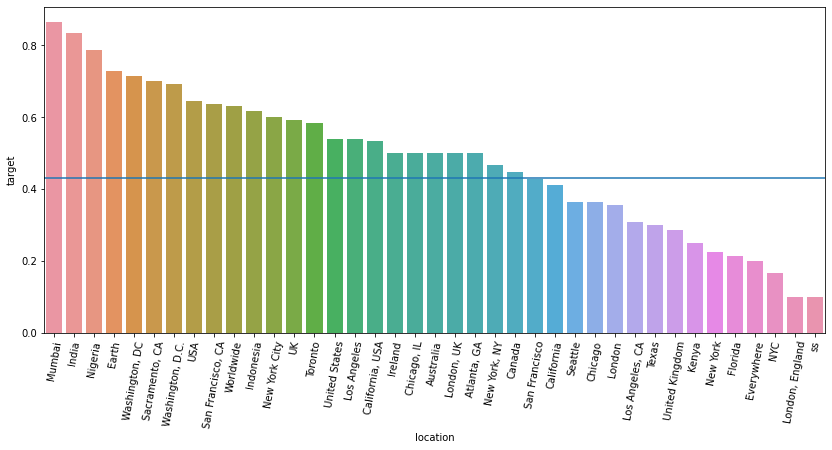

In [ ]:
raw_loc = train_csv.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_csv[train_csv.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train_csv.target))
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Samples of disaster and non-disaster tweets
display('Random sample of disaster tweets:', train_csv[train_csv.target==1].text.sample(3).to_frame())
display('Random sample of non disaster tweets:', train_csv[train_csv.target==0].text.sample(3).to_frame())

'Random sample of disaster tweets:'

,text
2573,Politics = Preschool Attitude: Russia orders t...
6966,@author_mike Amen today is the Day of Salvatio...
6038,#OilandGas Exploration Takes Seismic Shift in ...


'Random sample of non disaster tweets:'

,text
4965,http://t.co/HFqlwo1kMy E-Mini SP 500: Earnings...
5814,@accionempresa ChinaÛªs stock market crash th...
5745,To All The Meat-Loving Feminists Of The World ...


In [ ]:
# Words clouds of tweets
disaster_tweets = train_csv[train_csv['target']==1]['text']
non_disaster_tweets = train_csv[train_csv['target']==0]['text']

Text(0.5, 1.0, 'Non Disaster Tweets')

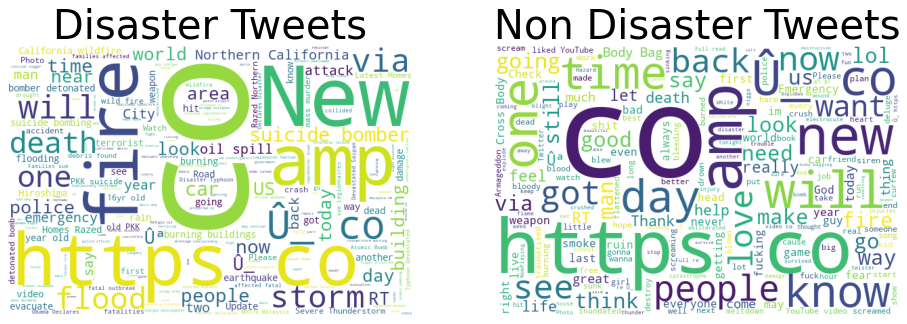

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40);

wordcloud2 = WordCloud(background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets', fontsize=40)

**Text preprocessing**

In [ ]:
# 1. Text Cleaning
# lowering the text
train_csv.text=train_csv.text.apply(lambda x:x.lower() )
test_csv.text=test_csv.text.apply(lambda x:x.lower())
# removing square brackets
train_csv.text=train_csv.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
train_csv.text=train_csv.text.apply(lambda x:re.sub('<.*?>+', '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('<.*?>+', '', x) )
# removing hyperlinks
train_csv.text=train_csv.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
# removing punctuation
train_csv.text=train_csv.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
train_csv.text=train_csv.text.apply(lambda x:re.sub('\n' , '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('\n', '', x) )
# remove words containing numbers
train_csv.text=train_csv.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
test_csv.text=test_csv.text.apply(lambda x:re.sub('\w*\d\w*', '', x) )

train_csv.text.head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
# 2. Tokenizer
token=nltk.tokenize.RegexpTokenizer(r'\w+')
# applying token
train_csv.text=train_csv.text.apply(lambda x:token.tokenize(x))
test_csv.text=test_csv.text.apply(lambda x:token.tokenize(x))
# view
display(train_csv.text.head())

0    [o, u, r, d, e, e, d, s, a, r, e, t, h, e, r, ...
1    [f, o, r, e, s, t, f, i, r, e, n, e, a, r, l, ...
2    [a, l, l, r, e, s, i, d, e, n, t, s, a, s, k, ...
3    [p, e, o, p, l, e, r, e, c, e, i, v, e, w, i, ...
4    [j, u, s, t, g, o, t, s, e, n, t, t, h, i, s, ...
Name: text, dtype: object

In [ ]:
nltk.download('stopwords')
# 3. Removing stopwords
train_csv.text=train_csv.text.apply(lambda x:[w for w in x if w not in stopwords.words('english')])
test_csv.text=test_csv.text.apply(lambda x:[w for w in x if w not in stopwords.words('english')])
# view
train_csv.text.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [u, r, e, e, r, e, h, e, r, e, n, f, h, e, r, ...
1    [f, r, e, f, r, e, n, e, r, l, r, n, g, e, k, ...
2    [l, l, r, e, e, n, k, e, h, e, l, e, r, n, p, ...
3    [p, e, p, l, e, r, e, c, e, v, e, w, l, f, r, ...
4    [j, u, g, e, n, h, p, h, f, r, r, u, b, l, k, ...
Name: text, dtype: object

In [ ]:
# 4. Stemming
# stemmering the text and joining
stemmer = nltk.stem.PorterStemmer()
train_csv.text=train_csv.text.apply(lambda x:" ".join(stemmer.stem(token) for token in x))
test_csv.text=test_csv.text.apply(lambda x:" ".join(stemmer.stem(token) for token in x))
# view
train_csv.text.head()

0    o u r   d e e d s   a r e   t h e   r e a s o ...
1    f o r e s t   f i r e   n e a r   l a   r o n ...
2    a l l   r e s i d e n t s   a s k e d   t o   ...
3      p e o p l e   r e c e i v e   w i l d f i r ...
4    j u s t   g o t   s e n t   t h i s   p h o t ...
Name: text, dtype: object

**Preparing sets for the training and assessing the models**

In [ ]:
train, valid = train_test_split(train_csv, test_size=0.2)
# 0.2 - 20% tweets in valid set

In [ ]:
print(X_train['text'])

6445    turkish troops killed in kurdish militant suic...
3870    aisumage akumareisu just between gray and ophe...
2431    tubestrike derailed you our robertwelch cutler...
5355    truly a scene of chaos unprecedented in frenzy...
6496    everything has sunk in except the fact that i ...
                              ...                        
4060    heartdisease us forest service says spending m...
1346    i will never support looting or the burning of...
3454               holy crap  my phone just exploded haha
7533    wreckage conclusively confirmed as from  malay...
3582    apd investigating fatal shooting of  year old ...
Name: text, Length: 6090, dtype: object


**Vectorization**

In [ ]:
# Vectorize the train, validation and test sets
count_vect = CountVectorizer()
train_set = count_vect.fit_transform(train['text']) #fit_transform only on training data
valid_set = count_vect.transform(valid['text'])
test_set = count_vect.transform(test_csv["text"])
# The fit method is calculating the mean and variance of each of the features present in our data.
# The transform method is transforming all the features using the respective mean and variance.

In [ ]:
# Preparing the data for testing the models
X_train_new = train_set
X_test_new = valid_set
y_train_new = train['target']
y_test_new = valid['target']

In [ ]:
train_set.shape

(6090, 11807)

In [ ]:
valid_set.shape

(1523, 11807)

In [ ]:
test_set.shape

(3263, 11807)

**Models**

In [ ]:
# 1. k-NN
# Let us find the appropriate number of neighbors
param_grid={'n_neighbors':np.arange(1,50)}
knn=KNeighborsClassifier()
knn_cv=GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(X_test_new, y_test_new)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [ ]:
knn_cv.best_params_

{'n_neighbors': 1}

In [ ]:
knn_cv.best_score_

0.6434511523907809

In [ ]:
kNN_model = KNeighborsClassifier(n_neighbors=1)
kNN_model.fit(X_train_new, y_train_new)

KNeighborsClassifier(n_neighbors=1)

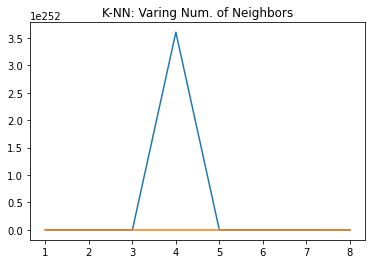

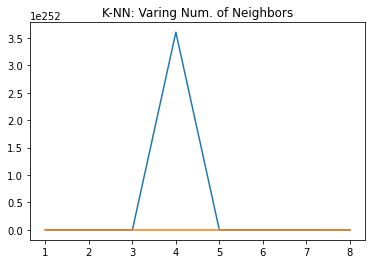

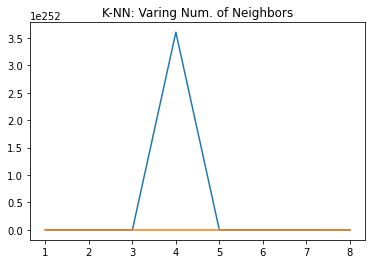

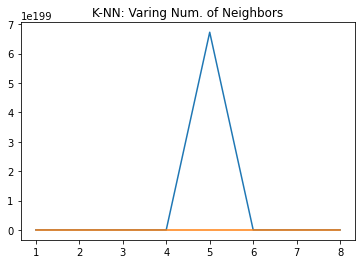

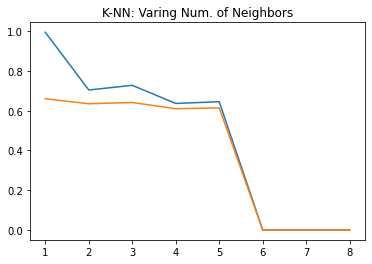

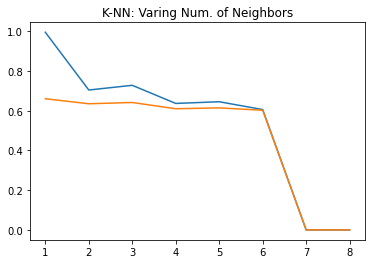

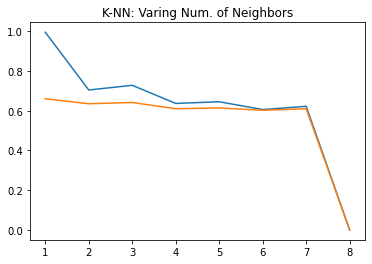

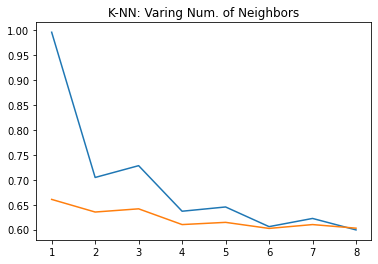

In [ ]:
nbrs=np.arange(1,9)
train_accuracy=np.empty(len(nbrs))
test_accuracy=np.empty(len(nbrs))
#Loop over different values of k
for i, k in enumerate(nbrs):
  knn=KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_test_new, y_test_new)
  train_accuracy[i]=knn.score(X_train_new, y_train_new)
  test_accuracy[i]=knn.score(X_test_new, y_test_new)
  plt.title('K-NN: Varing Num. of Neighbors')
  plt.plot(nbrs, test_accuracy, label='testing accuracy')
  plt.plot(nbrs, train_accuracy, label='training accuracy')
  plt.show()

In [ ]:
print(confusion_matrix(predictions, y_test_new))
print('*'*40)
print(classification_report(predictions, y_test_new))

NameError: ignored

In [ ]:
# 2. Logistic Regression
# Logistic Regression is almost equivalent to Linear Regression.
# The major difference between the two models is that, rather than integer values, the output of the logistic model is binary values.
c_space=np.logspace(-5,8,15)
param_grid={'C':c_space, 'penalty':['l1','l2']}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train_new, y_train_new)
print('Tunned Logistic Regresion Parameter: {}'.format(logreg_cv.best_params_))
print('Tunned Logistic Regresion Accuracy: {}'.format(logreg_cv.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Tunned Logistic Regresion Parameter: {'C': 0.4393970560760795, 'penalty': 'l2'}
Tunned Logistic Regresion Accuracy: 0.7990147783251231


In [ ]:
lr=LogisticRegression(C=0.4393970560760795, penalty='l2', random_state=42)
lr.fit(X_train_new, y_train_new)
predictions2 = lr.predict(X_test_new)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test_new, y_test_new)))

Accuracy of logistic regression classifier on test set: 0.79


In [ ]:
print(confusion_matrix(predictions2, y_test_new))
print('*'*40)
print(classification_report(predictions2, y_test_new))

[[750 209]
 [106 458]]
****************************************
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       959
           1       0.69      0.81      0.74       564

    accuracy                           0.79      1523
   macro avg       0.78      0.80      0.79      1523
weighted avg       0.81      0.79      0.80      1523



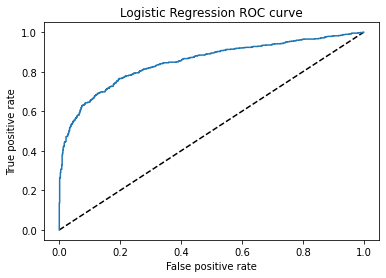

In [ ]:
y_pred_prob=lr.predict_proba(X_test_new)[:,1]
fpr, tpr, thresholds=roc_curve(y_test_new, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

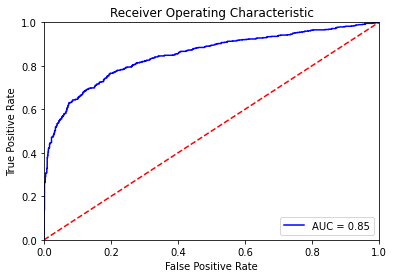

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
y_pred_prob=lr.predict_proba(X_test_new)[:,1]
fpr, tpr, thresholds=roc_curve(y_test_new, y_pred_prob)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
probs = lr.predict_proba(X_test_new)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_new, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# 3. Random Forest Classifier

param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_new, y_train_new)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_new, y_train_new)

RandomForestClassifier(random_state=42)

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
rf2=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [ ]:
rf2.fit(X_train_new, y_train_new)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [ ]:
prediction3=rf2.predict(X_test_new)

In [ ]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test_new,prediction3))

Accuracy for Random Forest on CV data:  0.6211424819435325


In [ ]:
print(confusion_matrix(prediction3, y_test_new))
print('*'*40)
print(classification_report(prediction3, y_test_new))

[[854 575]
 [  2  92]]
****************************************
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      1429
           1       0.14      0.98      0.24        94

    accuracy                           0.62      1523
   macro avg       0.57      0.79      0.49      1523
weighted avg       0.94      0.62      0.72      1523



In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train_new, y_train_new)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [ ]:
prediction4=clf.predict(X_test_new)

In [ ]:
print(confusion_matrix(prediction4, y_test_new))
print('*'*40)
print(classification_report(prediction4, y_test_new))

[[687 204]
 [169 463]]
****************************************
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       891
           1       0.69      0.73      0.71       632

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



In [ ]:
# Logistic Regression and Random Forest Classifier are not so different in the results, so we chose the 1st one
lr.fit(train_set, train['target'])
predictions = lr.predict(test_set)
print(predictions)

In [ ]:
prediction_df1 = pd.DataFrame(predictions)
frame = [test_csv['id'], prediction_df1]

result = pd.concat(frame, axis = 1)
result

,id,0
0,0,0.0
1,2,1.0
2,3,0.0
3,9,1.0
4,11,0.0
...,...,...
3258,10861,NaN
3259,10865,NaN
3260,10868,NaN
3261,10874,NaN


In [ ]:
result.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')